In [1]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle

In [4]:
!kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
  0% 0.00/149M [00:00<?, ?B/s]
100% 149M/149M [00:00<00:00, 1.63GB/s]


In [5]:
# !kaggle datasets list

In [6]:
! unzip -q /content/brain-tumor-mri-dataset.zip

(512, 512, 3)


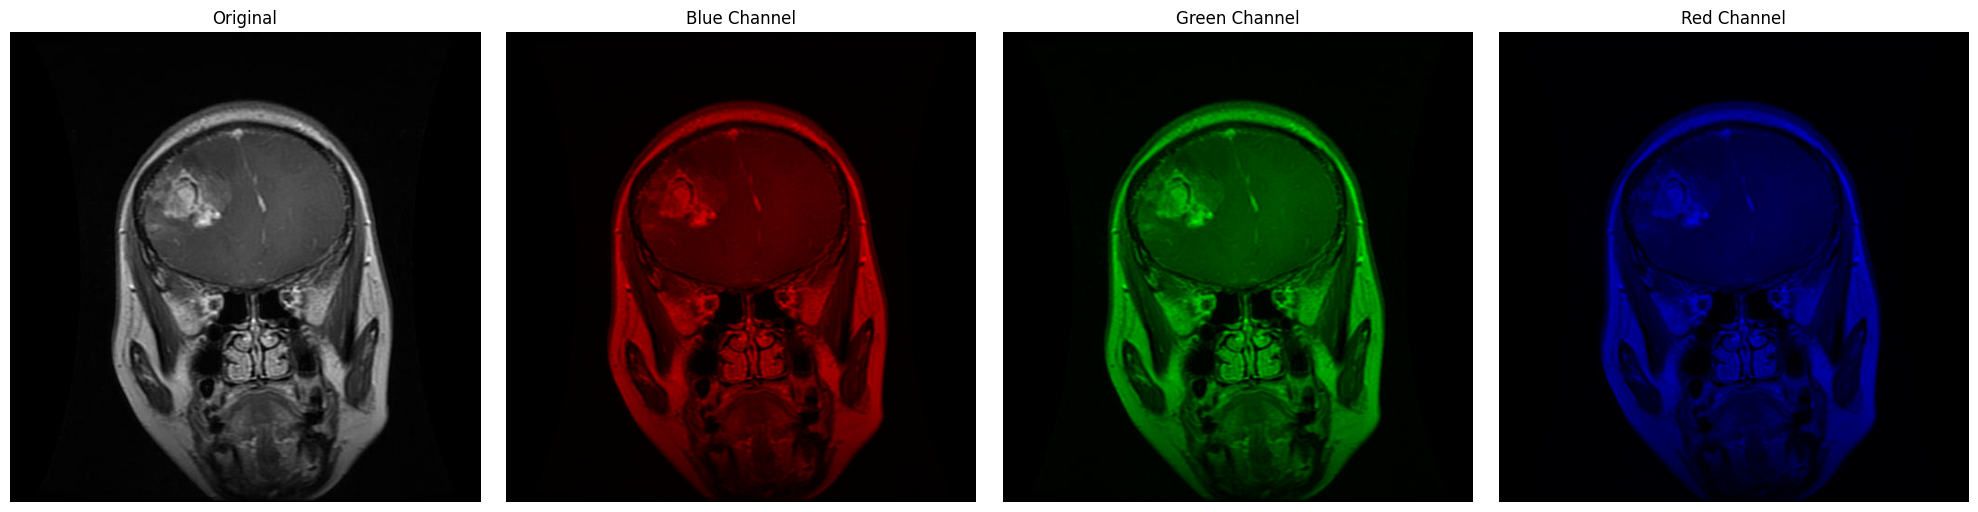

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread("/content/Training/glioma/Tr-glTr_0000.jpg")
print(image.shape)

if image is None:
    print("Error: Could not read the image. Please check the file path.")
else:
    # Convert the original image from BGR to RGB for correct display with Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Split the image into its B, G, and R channels
    b, g, r = cv2.split(image)

    # Create empty images to merge with the channels for visualization
    zeros = np.zeros(image.shape[:2], dtype="uint8")

    # Merge the channels to create colorized versions for display
    blue_channel = cv2.merge([b, zeros, zeros])
    green_channel = cv2.merge([zeros, g, zeros])
    red_channel = cv2.merge([zeros, zeros, r])

    # Create a figure and a set of subplots arranged in a 1x4 grid
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Use the axes objects to display each image in a different subplot
    axes[0].imshow(image_rgb)
    axes[0].set_title("Original")
    axes[0].axis('off')  # Hide the axes ticks and labels

    axes[1].imshow(blue_channel)
    axes[1].set_title("Blue Channel")
    axes[1].axis('off')

    axes[2].imshow(green_channel)
    axes[2].set_title("Green Channel")
    axes[2].axis('off')

    axes[3].imshow(red_channel)
    axes[3].set_title("Red Channel")
    axes[3].axis('off')

    # Adjust layout to prevent titles from overlapping
    plt.tight_layout()

    # Display the plot
    plt.show()


The label_mode argument in tf.keras.utils.

image_dataset_from_directory specifies how the labels for your images should be encoded. It is crucial for ensuring your dataset is correctly formatted for the chosen loss function in your machine learning model.

The possible values for label_mode are:

1. "int": This mode encodes labels as integers. It is suitable when your labels represent distinct classes, and you intend to use a loss function like sparse_categorical_crossentropy. The labels will be an int32 tensor of shape (batch_size,).

2. "binary": Use this mode when you have a binary classification problem (only two classes). Labels are encoded as float32 scalars with values 0 or 1. This is appropriate for loss functions such as binary_crossentropy. The labels will be a float32 tensor of shape (batch_size, 1).

3. "categorical": This mode encodes labels as a one-hot vector, where a single element in the vector is 1 and the rest are 0, representing the class. This is typically used with loss functions like categorical_crossentropy. The labels will be a float32 tensor of shape (batch_size, num_classes).

4. None: If you do not require labels, for example, in unsupervised learning or when you are only interested in the image data, you can set label_mode to None. In this case, the dataset will yield only image data, without corresponding labels.

The **FBetaScore** metric in Keras (specifically the one from tf.keras.metrics.FBetaScore) requires both the predictions ($\mathbf{y}_\text{pred}$) and the true labels ($\mathbf{y}_\text{true}$) to be in a one-hot encoded (or similar 2D format for multi-class classification) when dealing with multi-class or multi-label classification. We cant use sparse labels with it.

Hence Try to use categorical labels always.

In [8]:
import tensorflow as tf
from keras.utils import image_dataset_from_directory

training_path = '/content/Training'
testing_path = '/content/Testing'

image_size = (256, 256)
batch_size = 16

train_ds = image_dataset_from_directory(
    directory = training_path,
    labels = 'inferred',
    label_mode = 'categorical',
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = image_size,
    shuffle = True,
    seed = 42,
    verbose = True
)

validation_ds = image_dataset_from_directory(
    directory = testing_path,
    labels = 'inferred',
    label_mode = 'categorical',
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = image_size,
    shuffle = True,
    seed = 42,
    verbose = True
)



Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [9]:
train_ds.class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

# Visualization

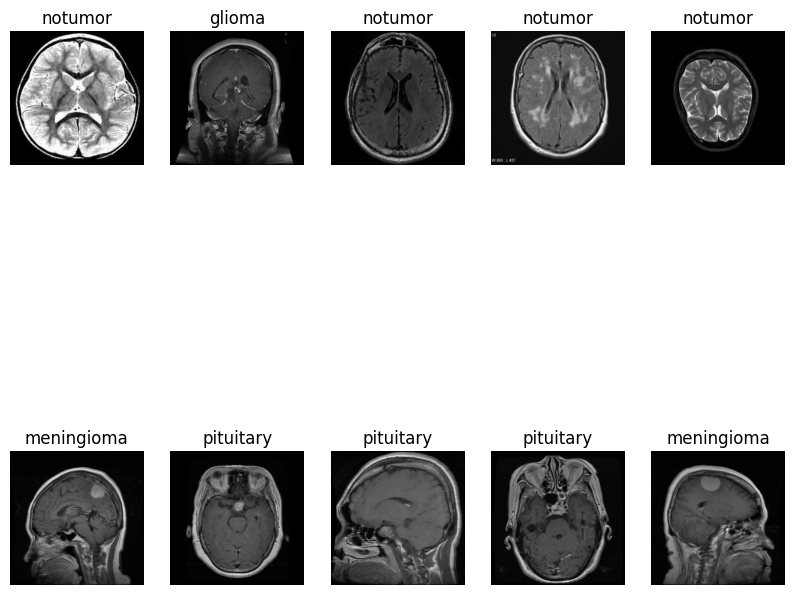

In [10]:
plt.figure(figsize = (10, 10))

for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[np.argmax(labels[i])])
    plt.axis("off")

# Model Building

In [11]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
from keras.models import Sequential

model = Sequential()

model.add( Rescaling(scale = 1./255, input_shape = (256, 256, 3) ))

model.add( Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = "valid"))
model.add( MaxPooling2D(pool_size = (2, 2), strides = 2))

model.add( Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = "valid"))
model.add( MaxPooling2D(pool_size = (2, 2), strides = 2))

# model.add( Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = "valid"))
# model.add( MaxPooling2D(pool_size = (2, 2), strides = 2))

model.add( Flatten())

model.add( Dense(128, activation = 'relu'))
model.add( Dense(64, activation = 'relu'))
model.add( Dense(4, activation = 'softmax'))

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 128)  │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    62,980,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,026,628 (240.43 MB)

 Trainable params: 63,026,628 (240.43 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy", "f1_score"]
)

history = model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs = 10
)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - accuracy: 0.6943 - f1_score: 0.6838 - loss: 0.8056 - val_accuracy: 0.8978 - val_f1_score: 0.8946 - val_loss: 0.2857
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 32s 57ms/step - accuracy: 0.9374 - f1_score: 0.9357 - loss: 0.1879 - val_accuracy: 0.9161 - val_f1_score: 0.9131 - val_loss: 0.2739
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.9643 - f1_score: 0.9634 - loss: 0.1014 - val_accuracy: 0.9100 - val_f1_score: 0.9075 - val_loss: 0.3083
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.9792 - f1_score: 0.9790 - loss: 0.0584 - val_accuracy: 0.9413 - val_f1_score: 0.9378 - val_loss: 0.2010
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.9854 - f1_score: 0.9853 - loss: 0.0500 - val_accuracy: 0.9489 - val_f1_score: 0.9460 - val_loss: 0.2409
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.9931 - f1_score: 0.9931 - loss: 0.0245 - val_accuracy: 0.9451 - val_f1_s

# Handling Overfitting

Note that we deliberately increased complexity to demonstrate overfitting.

We can verify whether overfitting has occured by observing or plotting
1. accuracy(training) vs val_accuracy.
2. f1_score(training) vs val_f1_score.
2. loss(training) vs val_loss

In [13]:
# history is model.fit() result object,
# that contains history dictoionary
# In that dictionary each entry is metrics name & that metrics' values at each step as list or tensor
print( history.history)

{'accuracy': [0.818802535533905, 0.9471288323402405, 0.9700630307197571, 0.9837185144424438, 0.9877451062202454, 0.9940476417541504, 0.9910714030265808, 0.9900209903717041, 0.9950980544090271, 0.994397759437561], 'f1_score': [<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.7929985 , 0.70430315, 0.8831646 , 0.8680879 ], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.93435115, 0.89412636, 0.97443885, 0.9770783 ], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9590194 , 0.9410018 , 0.98719144, 0.98800135], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.97909534, 0.9675736 , 0.9937421 , 0.99176383], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.986697  , 0.98103374, 0.9905956 , 0.99176383], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9928003 , 0.98805964, 0.9962382 , 0.9982847 ], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9817767 , 0.

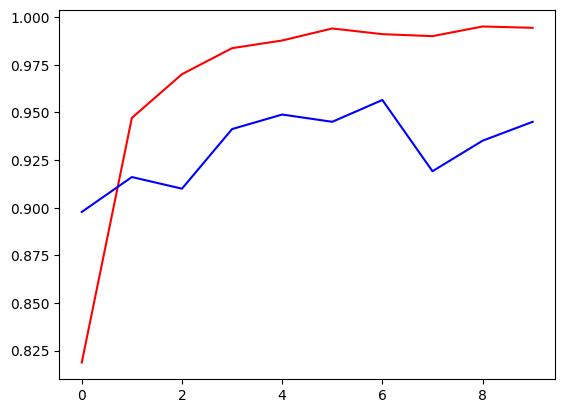

In [19]:
# Hence to plot just access any metric name as it is(training) and its validation version

plt.plot( history.history["accuracy"],color="red", label="train acccuracy")
plt.plot( history.history["val_accuracy"], color="blue", label = "validation accuracy")
plt.show()

Fluctuating/ decreasing val accuracy indicates overfitting

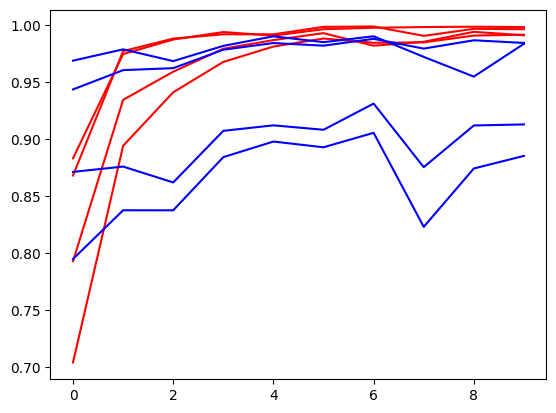

In [20]:
plt.plot( history.history["f1_score"],color="red", label="train f1_score")
plt.plot( history.history["val_f1_score"], color="blue", label = "validation f1_score")
plt.show()


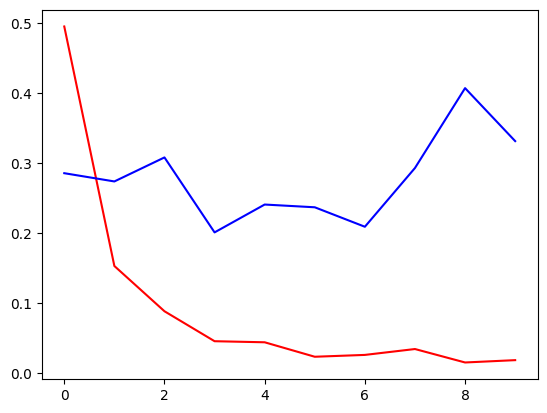

In [21]:
plt.plot( history.history["loss"],color="red", label="train loss")
plt.plot( history.history["val_loss"], color="blue", label = "validation loss")
plt.show()

# Techniques to address Overfitting in CNN

Here are some common techniques to address overfitting in CNNs:

*   **Data Augmentation**: This involves artificially increasing the size of your training dataset by applying random transformations to the existing images, such as rotation, zooming, shifting, flipping, and changing brightness. This helps the model generalize better to unseen data by exposing it to a wider variety of image variations.

*   **Regularization**: This technique adds a penalty to the loss function based on the complexity of the model. This discourages the model from learning overly complex patterns that might only be present in the training data. Common types include L1 and L2 regularization.

*   **Dropout**: During training, dropout randomly sets a fraction of the neurons in a layer to zero for each training sample. This prevents neurons from becoming too co-dependent and forces the network to learn more robust features.

*   **Batch Normalization**: This technique normalizes the inputs to each layer within a mini-batch during training. This helps stabilize the learning process and allows for higher learning rates, which can act as a regularizer.

*   **Early Stopping**: This involves monitoring the model's performance on a validation set during training and stopping the training process when the performance on the validation set starts to degrade, even if the training loss is still decreasing. This prevents the model from overfitting to the training data.

*   **Reduce Model Complexity**: Simplifying the model architecture by reducing the number of layers, filters, or neurons can help prevent overfitting, especially when dealing with smaller datasets.

*   **Cross-Validation**: While not a direct technique to modify the model, cross-validation helps in evaluating the model's performance more reliably by splitting the data into multiple folds and training/validating the model on different combinations of these folds. This gives a better estimate of how well the model will generalize to unseen data and can help in hyperparameter tuning to combat overfitting.

------------------
Lets try BatchNormalization(for CNN layers) and DropOut(for Dense layers).

setting Drop out to 0.2 or BatchNormalization in all made the model underfit instead. Haha

So lets keep :
dropout = 0.1,
BatchNormalization only in 1st layer

In [26]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, Dropout, BatchNormalization
from keras.models import Sequential

model = Sequential()

model.add( Rescaling(scale = 1./255, input_shape = (256, 256, 3) ))

model.add( Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = "valid"))
model.add( BatchNormalization())
model.add( MaxPooling2D(pool_size = (2, 2), strides = 2))

model.add( Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = "valid"))
model.add( MaxPooling2D(pool_size = (2, 2), strides = 2))

# model.add( Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = "valid"))
# model.add( MaxPooling2D(pool_size = (2, 2), strides = 2))

model.add( Flatten())

model.add( Dense(128, activation = 'relu'))
model.add( Dropout(0.1))

model.add( Dense(64, activation = 'relu'))
model.add( Dropout(0.1))

model.add( Dense(4, activation = 'softmax'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 125, 128)  │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    62,980,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,026,756 (240.43 MB)

 Trainable params: 63,026,692 (240.43 MB)

 Non-trainable params: 64 (256.00 B)

In [27]:
model.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy", "f1_score"]
)

history = model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs = 10
    )

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - accuracy: 0.5763 - f1_score: 0.5710 - loss: 6.9525 - val_accuracy: 0.6850 - val_f1_score: 0.6641 - val_loss: 1.0232
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.8292 - f1_score: 0.8260 - loss: 0.4530 - val_accuracy: 0.8665 - val_f1_score: 0.8582 - val_loss: 0.3587
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.8908 - f1_score: 0.8880 - loss: 0.2947 - val_accuracy: 0.8314 - val_f1_score: 0.8224 - val_loss: 0.4763
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9215 - f1_score: 0.9192 - loss: 0.2233 - val_accuracy: 0.8970 - val_f1_score: 0.8907 - val_loss: 0.3171
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9617 - f1_score: 0.9610 - loss: 0.1076 - val_accuracy: 0.9306 - val_f1_score: 0.9268 - val_loss: 0.2513
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9619 - f1_score: 0.9610 - loss: 0.1046 - val_accuracy: 0.9092 - val_f1_s

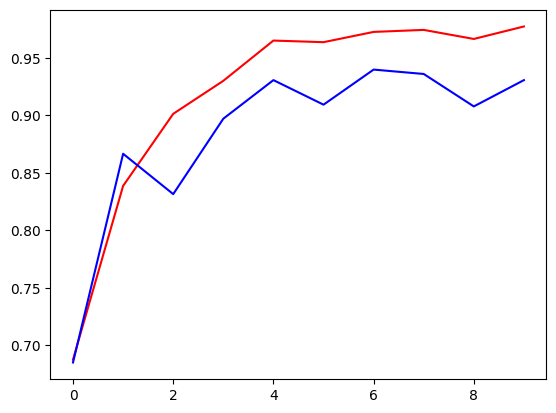

In [28]:
plt.plot( history.history["accuracy"],color="red", label="train acccuracy")
plt.plot( history.history["val_accuracy"], color="blue", label = "validation accuracy")
plt.show()

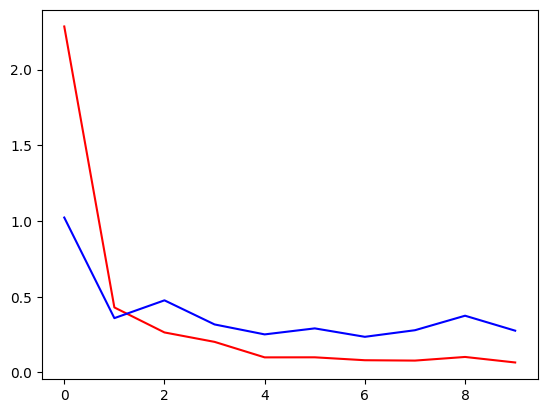

In [29]:
plt.plot( history.history["loss"],color="red", label="train loss")
plt.plot( history.history["val_loss"], color="blue", label = "validation loss")
plt.show()

We can see its more under control now!!

--------------
The **learning rate** is a hyperparameter that determines the step size at each iteration while moving towards a minimum of the loss function. It controls how much the model's weights are updated in response to the estimated error during training.

Here's a breakdown of its impact:

*   **Impact on Performance:**
    *   **Too High Learning Rate:** If the learning rate is too high, the model might overshoot the optimal solution and fail to converge. This can lead to the loss function oscillating around the minimum or even diverging. The model might never find the best set of weights.
    *   **Too Low Learning Rate:** If the learning rate is too low, the model will take very small steps towards the minimum. This can result in a very slow training process and the model might get stuck in a local minimum rather than finding the global minimum.
    *   **Optimal Learning Rate:** An optimal learning rate allows the model to converge efficiently and find a good minimum of the loss function, leading to better performance on both training and validation data.

*   **Impact on Overfitting and Underfitting:**
    *   **Too High Learning Rate:** A high learning rate can sometimes act as a form of regularization, preventing the model from settling into a very sharp minimum that might only fit the training data well (overfitting). However, as mentioned, it can also prevent convergence altogether.
    *   **Too Low Learning Rate:** A low learning rate can increase the risk of overfitting, especially with complex models. The model has more time to fine-tune its weights to the specific details of the training data, which might not generalize well to unseen data.

**How to Change Learning Rate in Keras/TensorFlow:**

In Keras and TensorFlow, you typically set the learning rate when defining your optimizer. Here are a few ways:

1.  **Directly in the Optimizer:**

In [ ]:
    from tensorflow.keras.optimizers.schedules import ExponentialDecay
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import LearningRateScheduler

    # Define a learning rate schedule
    initial_learning_rate = 0.01
    lr_schedule = ExponentialDecay(
        initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
    )

    optimizer = Adam(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer, ...)

    # To use the scheduler during training, add it as a callback
    # history = model.fit(train_ds, validation_data=validation_ds, epochs=10, callbacks=[LearningRateScheduler(lr_schedule)]) # Note: LearningRateScheduler needs a function, not a schedule object directly. A LambdaCallback is often used with schedules.

    # A more common way to use schedules with callbacks
    from tensorflow.keras.callbacks import ReduceLROnPlateau

    # Reduce learning rate when a metric has stopped improving.
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)

    history = model.fit(train_ds, validation_data=validation_ds, epochs=10, callbacks=[reduce_lr])

2. Using Callbacks (LearningRateScheduler):
The tf.keras.callbacks.LearningRateScheduler callback allows for dynamic adjustment of the learning rate based on a custom function provided by the user. This function takes the current epoch number as input and returns the desired learning rate for that epoch.

In [ ]:

import tensorflow as tf

def lr_schedule(epoch):
    if epoch < 10:
        return 0.01
    elif epoch < 20:
        return 0.005
    else:
        return 0.001

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# Compile your model with an optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

# Train your model, passing the callback
model.fit(x_train, y_train, epochs=30, callbacks=[lr_callback])

3. Manually Changing Learning Rate during Training (less common):
While less common for structured schedules, you can also manually change the learning rate of an optimizer within a custom training loop or by accessing the optimizer's learning_rate attribute.


In [ ]:
import tensorflow.keras.backend as K

# ... (model definition and compilation)

# Train for some epochs
model.fit(x_train, y_train, epochs=10)

# Change the learning rate
K.set_value(model.optimizer.learning_rate, 0.001)

# Continue training with the new learning rate
model.fit(x_train, y_train, epochs=10, initial_epoch=10)